In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import zipfile
from datetime import datetime
from pandas_gbq import *
from pandas_gbq import to_gbq
from pandas_gbq import read_gbq
from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
## define project and set up paths for Google Big Query
service_path = "C:/Users/breni/Documents/"
service_file = 'niekampbreannawedge-8bbebeea1dda.json'
project_id = 'niekampbreannawedge'
data_id = 'wedge24'

beans_key = service_path + service_file

In [3]:

credentials = service_account.Credentials.from_service_account_file(beans_key)

client = bigquery.Client(credentials= credentials, project= project_id)

In [4]:
conn = sqlite3.connect('wedge_summary.db')

# Task 3: Building Summary Tables

In this task, summary files will be created that allow quick answers to certain questions. In order to do this, a single SQLite database will be created in python (in a .db file) containing three tables as follows: 
1. Sales by date by hour
2. Sales by Owner by Year by Month
3. Sales by Product Description by Year by Month

This database will be built with Python below!

In [5]:
## Query 1: Sales by Date by Hour: By calendar date (YYYY-MM-DD) and hour of the day, 
# determine the total spend in the store, 
# the number of transactions, 
# and a count of the number of items.

query1 = """
    SELECT 
        EXTRACT(DATE FROM datetime) as sale_date, 
        EXTRACT(HOUR FROM datetime) as sale_hour,
        ROUND(SUM(total), 2) as total_sales,
        COUNT(DISTINCT CONCAT(
            CAST(EXTRACT(DATE FROM datetime) AS STRING),
            CAST(register_no AS STRING),
            CAST(emp_no AS STRING),
            CAST(trans_no AS STRING)
        )) AS num_transactions,
        SUM(
            CASE
                WHEN trans_status IN ('V', 'R') THEN -1
                ELSE 1
            END
        ) AS total_items
    FROM `umt-msba.wedge_transactions.transArchive*` AS trans
    JOIN `umt-msba.wedge_transactions.department_lookup` AS depts
        ON trans.department = depts.department
    WHERE trans.department NOT IN (0, 15)
        AND card_no != 3
        AND (trans_status IS NULL
            OR trans_status IN ('V', 'R', '', ' '))
    GROUP BY sale_date, sale_hour
    ORDER BY sale_date, sale_hour;
    
"""

df_transactions = read_gbq(query1, project_id= project_id)

Downloading: 100%|██████████|


In [6]:
df_transactions

,sale_date,sale_hour,total_sales,num_transactions,total_items
0,2010-01-01,9,717.50,18,175
1,2010-01-01,10,2665.77,55,757
2,2010-01-01,11,2824.45,65,778
3,2010-01-01,12,2523.37,75,773
4,2010-01-01,13,3789.56,104,1091
...,...,...,...,...,...
38833,2017-01-31,18,5478.42,171,1312
38834,2017-01-31,19,3803.19,132,997
38835,2017-01-31,20,3577.06,102,954
38836,2017-01-31,21,2353.89,77,683


In [7]:
# saving the table
df_transactions.to_sql('sales_by_date_hour', conn, if_exists='append', index=False)

38838

In [8]:
## TASK 2: Sales by Owner by Year by Month: A file that has the following columns: 
# card_no, year, month, sales, transactions, and items.
query2 = """
    SELECT card_no,
        EXTRACT(YEAR FROM datetime) as year, 
        EXTRACT(MONTH FROM datetime) as month,
        ROUND(SUM(total), 2) as total_sales,
        COUNT(DISTINCT CONCAT(
            CAST(EXTRACT(DATE FROM datetime) AS STRING),
            CAST(register_no AS STRING),
            CAST(emp_no AS STRING),
            CAST(trans_no AS STRING)
        )) AS num_transactions,
        SUM(
            CASE
                WHEN trans_status IN ('V', 'R') THEN -1
                ELSE 1
            END
        ) AS total_items
    FROM `umt-msba.wedge_transactions.transArchive*` AS trans
    JOIN `umt-msba.wedge_transactions.department_lookup` AS depts
        ON trans.department = depts.department
    WHERE trans.department NOT IN (0, 15)
        AND card_no != 3
        AND (trans_status IS NULL
            OR trans_status IN ('V', 'R', '', ' '))
    GROUP BY card_no, year, month
    ORDER BY year, month;
    
"""

df_sales_by_owner = read_gbq(query2, project_id= project_id)

Downloading: 100%|██████████|


In [9]:
df_sales_by_owner

,card_no,year,month,total_sales,num_transactions,total_items
0,22018.0,2010,1,533.42,7,122
1,19611.0,2010,1,126.30,3,30
2,14689.0,2010,1,359.37,8,55
3,50615.0,2010,1,223.68,3,46
4,50981.0,2010,1,220.99,9,67
...,...,...,...,...,...,...
808806,48542.0,2017,1,23.90,2,4
808807,15038.0,2017,1,54.70,1,12
808808,17376.0,2017,1,44.43,1,9
808809,25510.0,2017,1,103.78,1,12


In [10]:
# saving, but had to fix it (hence the replace)
df_sales_by_owner.to_sql('sales_by_owner_year_month', conn, if_exists='replace', index=False)


808811

In [11]:
## TASK 3: : A file that has the following columns: upc, description, 
# department number, department name, year, month, sales, transactions, and items

query3 = """
    SELECT 
        trans.upc,
        trans.description,
        trans.department as department_num,
        depts.dept_name,
        EXTRACT(YEAR FROM trans.datetime) as year,
        EXTRACT(MONTH FROM trans.datetime) as month,
        ROUND(SUM(trans.total), 2) as total_sales,
        COUNT(DISTINCT CONCAT(
            CAST(EXTRACT(DATE FROM trans.datetime) AS STRING),
            CAST(trans.register_no AS STRING),
            CAST(trans.emp_no AS STRING),
            CAST(trans.trans_no AS STRING)
        )) AS num_transactions,
        SUM(
            CASE
                WHEN trans.trans_status IN ('V', 'R') THEN -1
                ELSE 1
            END
        ) AS total_items
    FROM `umt-msba.wedge_transactions.transArchive*` AS trans
    JOIN `umt-msba.wedge_transactions.department_lookup` AS depts
        ON trans.department = depts.department
    WHERE trans.department NOT IN (0, 15)
        AND (CAST(trans.upc AS STRING) != '0' 
            OR trans.upc IS NULL)
    AND (CAST(trans.card_no AS STRING) != '3' 
        OR trans.card_no IS NULL)
    AND (trans.trans_status IS NULL
        OR trans.trans_status IN ('V', 'R', '', ' '))
GROUP BY trans.upc, trans.description, trans.department, depts.dept_name, year, month
ORDER BY year, month;
    
"""

df_sales_by_product = read_gbq(query3, project_id=project_id)

Downloading: 100%|██████████|


In [12]:
df_sales_by_product

,upc,description,department_num,dept_name,year,month,total_sales,num_transactions,total_items
0,0978076494744,Cat in Garden Calendar 2010,9.0,GEN MERCH,2010,1,13.99,1,1
1,0003149303159,O.Spelt Bread 20oz Rudis,7.0,BREAD,2010,1,250.20,49,60
2,0066763430032,Odor Eliminator 32oz Atmos,1.0,PACKAGED GROCERY,2010,1,89.94,6,6
3,0007433347044,Creamy Peanut Butter 26oz Ar,1.0,PACKAGED GROCERY,2010,1,146.79,21,21
4,0002995690710,Ashtanga Yoga DVD,9.0,GEN MERCH,2010,1,22.49,1,1
...,...,...,...,...,...,...,...,...,...
1130885,0000000013710,SEEDS Radish Sprouting,3.0,BULK,2017,1,21.61,5,5
1130886,0069765820102,O.Hemp Seed Oil 16.9oz MaH,10.0,SUPPLEMENTS,2017,1,39.98,2,2
1130887,0000000000043,OBLONG Pumpernickel Bread,8.0,DELI,2017,1,285.16,69,67
1130888,0020115400000,Chewy Trail Mix Cookie,8.0,DELI,2017,1,30.43,16,17


In [13]:
# saving
df_sales_by_product.to_sql('sales_by_product_year_month', conn, if_exists='append', index=False)

1130890

In [14]:
### always close the connection!!!
conn.close()

## Validating the Database 

Now that the database should be created, it is important to validate it to ensure that information can be pulled from it and it's in working. 

In [15]:
### Ensuring db file was created and is in working fashion
 
conn = sqlite3.connect('wedge_summary.db')

# List all tables in db
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print("Tables in the database:")
print(tables)

# Query and display data from the tables
df = pd.read_sql("SELECT * FROM sales_by_date_hour LIMIT 5;", conn)
print("First 5 rows from sales_by_date_hour:")
print(df)

df2 = pd.read_sql("SELECT * FROM sales_by_owner_year_month LIMIT 5;", conn)
print("First 5 rows from sales_by_owner_year_month:")
print(df2)

df3 = pd.read_sql("SELECT * FROM sales_by_product_year_month LIMIT 5;", conn)
print("First 5 rows from sales_by_product_year_month:")
print(df3)

# Close the connection when done
conn.close()

Tables in the database:
                          name
0           sales_by_date_hour
1  sales_by_product_year_month
2    sales_by_owner_year_month
First 5 rows from sales_by_date_hour:
    sale_date  sale_hour  total_sales  num_transactions  total_items
0  2010-01-01          9       717.50                18          175
1  2010-01-01         10      2665.77                55          757
2  2010-01-01         11      2824.45                65          778
3  2010-01-01         12      2523.37                75          773
4  2010-01-01         13      3789.56               104         1091
First 5 rows from sales_by_owner_year_month:
   card_no  year  month  total_sales  num_transactions  total_items
0  22018.0  2010      1       533.42                 7          122
1  19611.0  2010      1       126.30                 3           30
2  14689.0  2010      1       359.37                 8           55
3  50615.0  2010      1       223.68                 3           46
4  50981.0  201

## Answering Business Questions: 

This task provided us with three questions to consider when building the tables that were added to the database. Lets give it a go!

1. How have our sales-by-day changed over the last few months?

2. What is our most popular item in each department?

3. Which owners spend the most per month in each department?

In [16]:
# Connect to your SQLite database
conn = sqlite3.connect('wedge_summary.db')

# Query 1: Sales by day trend
query_sales_by_day = """
    SELECT sale_date, SUM(total_sales) AS daily_sales
    FROM sales_by_date_hour
    GROUP BY sale_date
    ORDER BY sale_date DESC
    LIMIT 90;
"""
df_sales_by_day = pd.read_sql(query_sales_by_day, conn)
print("Sales by Day (Last 90 Days):")
print(df_sales_by_day)

Sales by Day (Last 90 Days):
     sale_date  daily_sales
0   2017-01-31    268035.30
1   2017-01-30    266656.70
2   2017-01-29    428051.35
3   2017-01-28    398670.10
4   2017-01-27    289503.40
..         ...          ...
85  2016-11-06    465974.90
86  2016-11-05    355024.60
87  2016-11-04    261106.15
88  2016-11-03    240972.05
89  2016-11-02    265904.30

[90 rows x 2 columns]


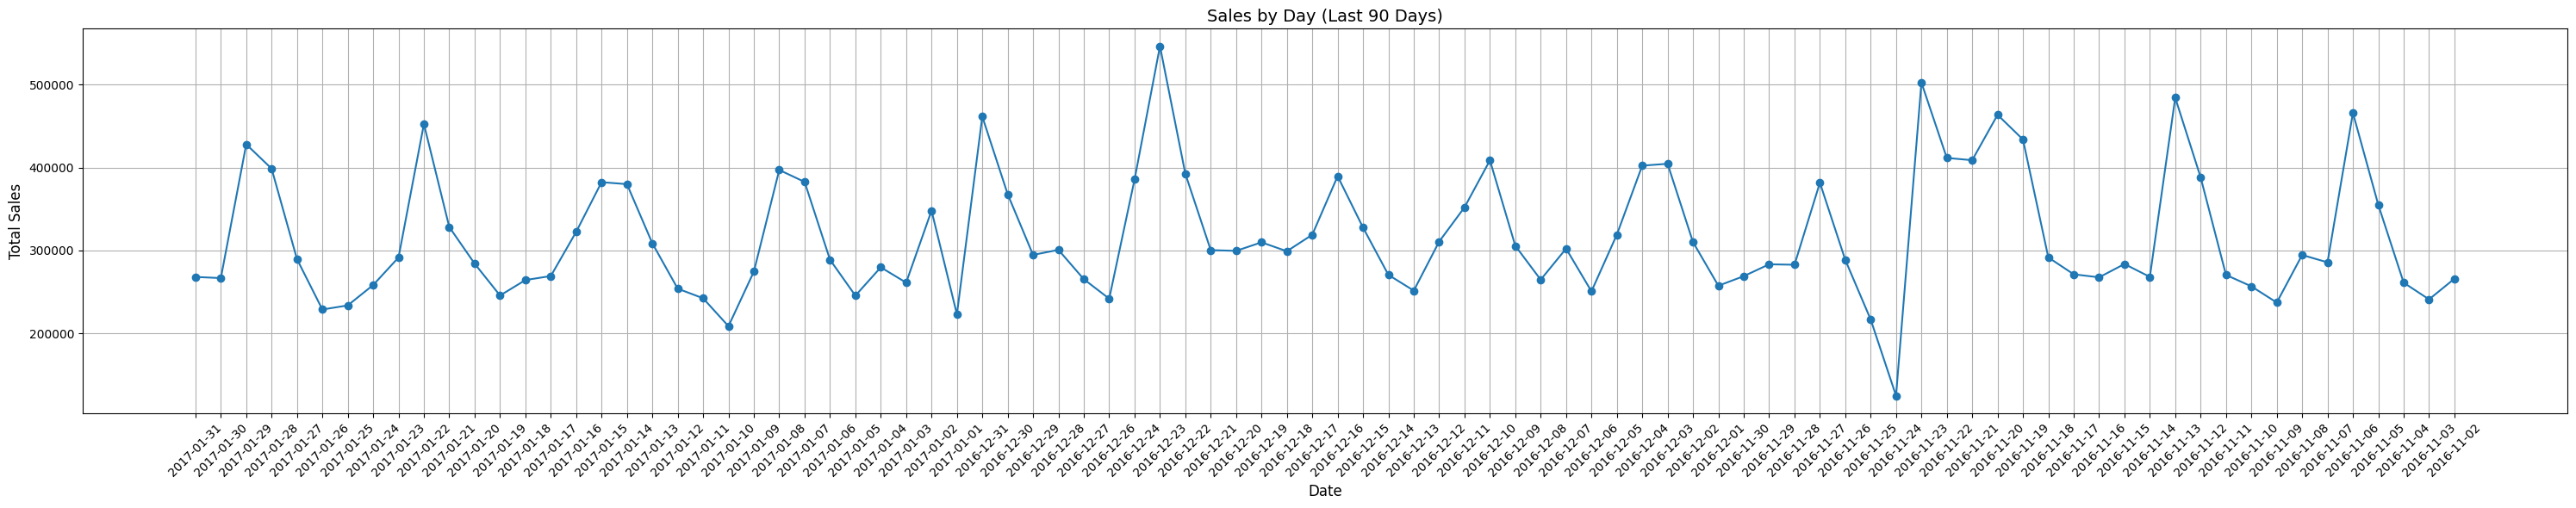

In [17]:
# visualize sales by day
plt.figure(figsize=(30,6))
plt.plot(df_sales_by_day['sale_date'], df_sales_by_day['daily_sales'], marker='o')
plt.title('Sales by Day (Last 90 Days)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The plot above appears to have the worst day for sales around November 25, 2016. This is the period around Thanksgiving. After having a look at the calendar, that day appears on a Friday. Perhaps this could be associated with Black Friday or even "national leftovers". It would seem over the last few months that the highest sales day occurred on December 24, 2017. This was a Saturday and also Christmas Eve. This might be influenced by a lot of last minute shoppers hoping to fulfill their holiday needs. It is worth noting that the shape of this line graph shows a slight decline in variability starting in 2017. Based on the differences that can be seen visually, I believe that this is due to the fac that in 2017 the Missoula Community Food Co-op went out of business (as per the assignment introduction) but that may be far reaching without additional tests to support the theory. Additionally, another observation might include that perhaps the holidays are more variable for high and low purchase days than non holiday dates or dates that dont fall too close to holidays.

In [18]:
# Query 2: Most popular item in each department
query_popular_item = """
    WITH item_sales AS (
        SELECT upc, description, department_num, dept_name, SUM(total_items) AS total_items_sold
        FROM sales_by_product_year_month
        GROUP BY upc, description, department_num, dept_name
    )
    SELECT department_num, dept_name, upc, description, MAX(total_items_sold) AS most_items_sold
    FROM item_sales
    GROUP BY department_num, dept_name;
"""
df_popular_item = pd.read_sql(query_popular_item, conn)
print("\nMost Popular Item in Each Department:")
print(df_popular_item)



Most Popular Item in Each Department:
    department_num         dept_name            upc  \
0              1.0  PACKAGED GROCERY  0000000001015   
1              2.0           PRODUCE  0000000000051   
2              3.0              BULK  0000000013595   
3              4.0       REF GROCERY  0081076600001   
4              5.0            CHEESE  0020503900000   
5              6.0            FROZEN  0002428465111   
6              7.0             BREAD  0000000001086   
7              8.0              DELI  0000000000099   
8              9.0         GEN MERCH  0000000001054   
9             10.0       SUPPLEMENTS     WWDISCOUNT   
10            11.0     PERSONAL CARE  0000000003602   
11            12.0      HERBS&SPICES  0000000019082   
12            13.0              MEAT  0020600300000   
13            14.0         JUICE BAR  0000000040400   
14            16.0      FISH&SEAFOOD  0020685400000   
15            17.0         BAKEHOUSE  0000000000093   
16            18.0        

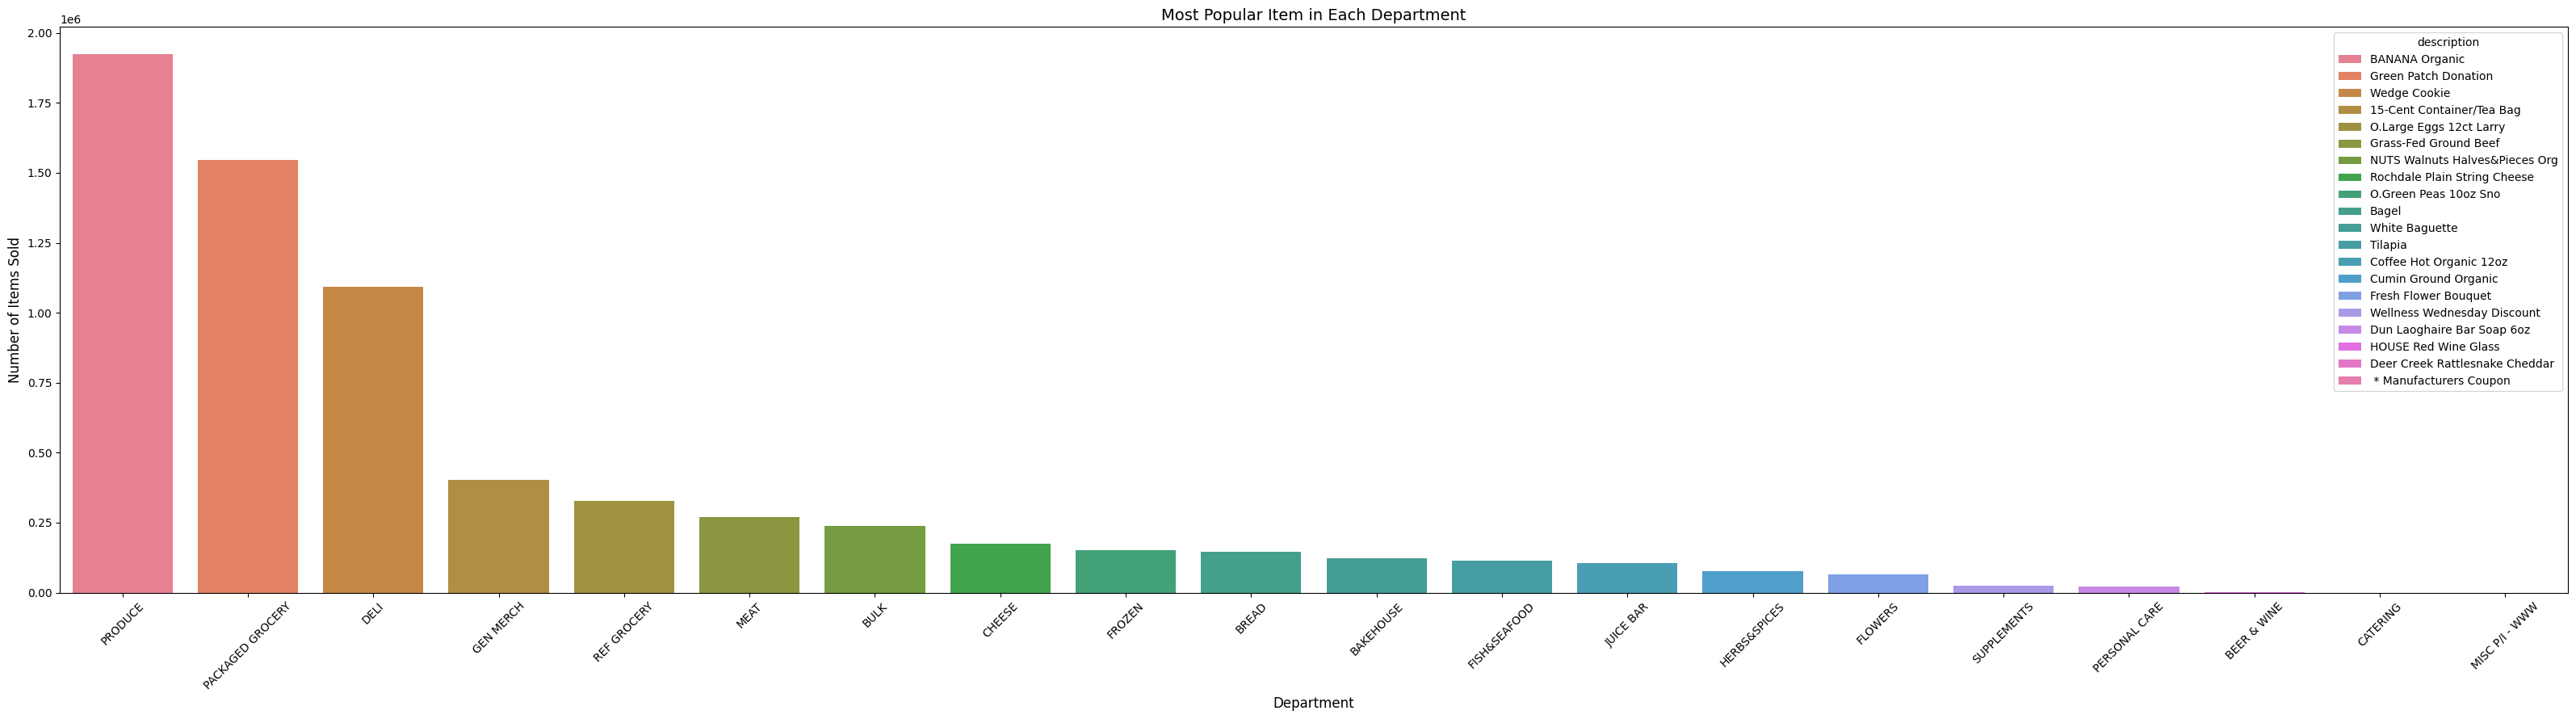

In [19]:
# visualize
df_popular_item_sorted = df_popular_item.sort_values(by='most_items_sold', ascending=False)

plt.figure(figsize=(32,9))
sns.barplot(data=df_popular_item_sorted, x='dept_name', y='most_items_sold', hue='description', dodge=False)
plt.title('Most Popular Item in Each Department', fontsize=14)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Number of Items Sold', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As shown above, we can see that the Organic Bananas are leading the charts in produce followed by Green Patch Donations, and Wedge Cookies in the packaged grocery and deli departments. 

In [20]:
query_top_owners = """
    SELECT 
        card_no, 
        year, 
        month, 
        SUM(total_sales) AS total_spent
    FROM 
        sales_by_owner_year_month
    WHERE card_no IS NOT NULL
    GROUP BY 
        card_no, year, month
    ORDER BY 
        total_spent DESC
    LIMIT 100;
"""
df_top_owners = pd.read_sql(query_top_owners, conn)
print("\nTop Spending Owners:")
print(df_top_owners)


Top Spending Owners:
    card_no  year  month  total_spent
0   12539.0  2015      5     75806.80
1   12539.0  2015      7     74415.36
2   12539.0  2015      3     71805.47
3   12539.0  2015      9     71750.48
4   12539.0  2014      5     70799.73
..      ...   ...    ...          ...
95  10499.0  2011      5     36882.98
96  10499.0  2012     11     36668.16
97  10499.0  2011     12     36631.15
98  10499.0  2010     12     36082.72
99  10499.0  2013      1     36027.80

[100 rows x 4 columns]


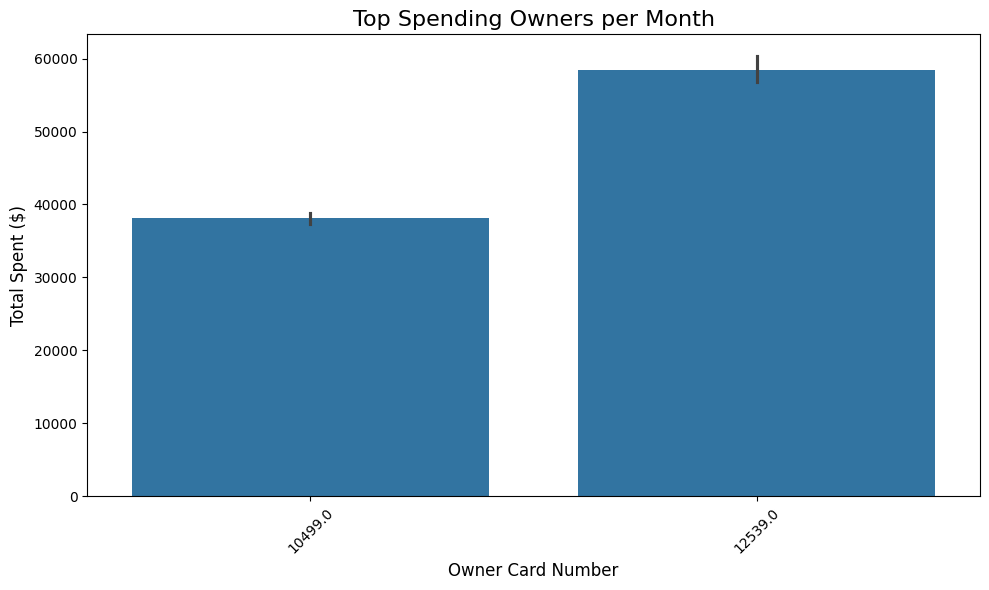

In [21]:
# visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_owners, x='card_no', y='total_spent')
plt.title('Top Spending Owners per Month', fontsize=16)
plt.xlabel('Owner Card Number', fontsize=12)
plt.ylabel('Total Spent ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Close the database connection
conn.close()